In [1]:
import os
import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider

from Preprocessing_Methods import *


In [2]:
file_names = glob.glob('/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_new/*')

annotations = dict()

for file_name in tqdm(file_names):
    for i in [1,2]:
        try:
            annotations[f"{file_name.split('/')[-1][:-4]}"] = matplotlib.image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][:-4]}.png")  
            continue

        except FileNotFoundError as e:

            pass
            #print(f'{file_name} not found')

In [8]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, normalize

In [2]:
master = pd.read_excel('./master_xl.xlsx')
gb = list(master.groupby('REF'))

In [5]:
gb[0][1]

,Unnamed: 0,HE,REF,TMA,ANN,FTIR
0,0,/mnt/c/Users/conor/Google Drive/PhD/H&E_Cores/...,TMA_1_A10,TMA_1,/mnt/c/Users/conor/Google Drive/PHD/Project wi...,/mnt/c/Users/conor/OneDrive/Desktop/temp_extra...
1,1,/mnt/c/Users/conor/Google Drive/PhD/H&E_Cores/...,TMA_1_A10,TMA_1,/mnt/c/Users/conor/Google Drive/PHD/Project wi...,/mnt/c/Users/conor/OneDrive/Desktop/temp_extra...


In [10]:
total = pd.read_pickle('./Original_Data.pickle')
total['1yeardeath'] = (total.reset_index()['survival (months)']<12).values & (total.reset_index('DiedvsAlive')['DiedvsAlive']=='Died').values
total = total.set_index('1yeardeath', append=True)
total = truncate(total, start=1000, end=1800)

In [13]:
patients = total.reset_index().groupby('Patient_Number').sample(1).iloc[:,:43]

In [14]:
# Truncate and eliminate paraffin contribution

total_p = pd.DataFrame(FunctionTransformer(normalize, kw_args = {"axis": 1}).fit_transform(total), index=total.index, columns=total.columns)
total_p = total_p.sample(frac=1)

In [15]:
aggdict = {'age @ diag': [np.mean]
         , 'gender':[len]
         , 'N stage': [len]}

In [16]:
def range(array):

    return f'{array.min()} - {array.max()}'


In [17]:
range(np.array([5,6,7]))

'5 - 7'

In [12]:
table = patients.pivot_table('age @ diag', '1yeardeath', aggfunc=[np.mean, range, np.median]).T

In [13]:
table = pd.crosstab(patients['age @ diag'], patients['1yeardeath'], margins=True)

print(table)

1yeardeath  False  True  All
age @ diag                  
29              1     0    1
44              1     0    1
48              3     0    3
50              1     0    1
51              1     0    1
52              2     0    2
53              1     0    1
56              2     0    2
57              1     0    1
58              1     0    1
59              1     1    2
61              1     1    2
62              1     0    1
63              2     0    2
64              1     2    3
67              1     0    1
68              1     0    1
70              1     1    2
71              0     1    1
72              1     0    1
74              0     2    2
82              0     1    1
85              0     1    1
All            24    10   34


In [14]:
table.to_latex('./Prognosis_Paper_Plots/table.txt')

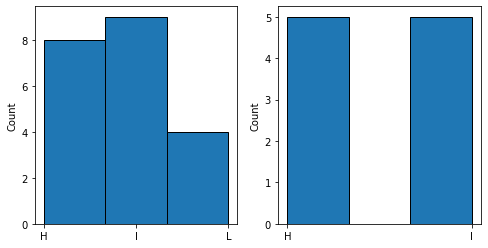

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

for ax, (name, df) in zip(axes, patients.groupby('1yeardeath')):

    df.sort_values(by='ASMA')['ASMA'].hist(ax=ax, bins=3, edgecolor='black', grid=False, histtype='barstacked', rwidth=1.0)
    ax.set_ylabel('Count')

In [16]:
pd.crosstab(index=[patients['2year'], patients['ASMA']], columns='Patient_Number', aggfunc=len, values=patients['1yeardeath'], margins=True).iloc[:-1,:]

col_0       Patient_Number  All
2year ASMA                     
False H                  5    5
      I                  8    8
      L                  3    3
True  H                  8    8
      I                  6    6
      L                  1    1

TMA_1_C3
<ipython-input-41-242a76d836c5>:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


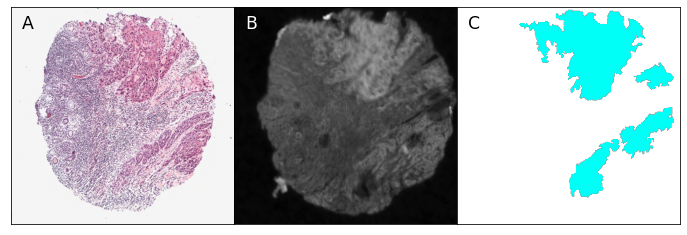

In [41]:
row = gb[16]

name = row[0]
print(name)

df1 = row[1].iloc[0,:]

ftir = pd.read_hdf(df1['FTIR'], key='Data')

ann = matplotlib.image.imread('/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_1/TMA_1.1_C3.png')

he1 = matplotlib.image.imread(df1['HE'])



fig, axes = plt.subplots(ncols=3, figsize=(12,4), constrained_layout = True)
fig.subplots_adjust(wspace=0)

axes[0].imshow(he1,aspect='auto')
axes[0].text(0.05, 0.9, 'A', size='xx-large', transform=axes[0].transAxes)
axes[1].imshow(ftir.values.reshape(256,256,-1)[25:,:,195],aspect='auto', cmap='gray')
axes[1].text(0.05, 0.9, 'B', size='xx-large', color='w', transform=axes[1].transAxes)
axes[2].imshow(ann[25:,:,:],aspect='auto')
axes[2].text(0.05, 0.9, 'C', size='xx-large', transform=axes[2].transAxes)

[(ax.set_xticks([]), ax.set_yticks([])) for ax in axes];

fig.savefig('./Prognosis_Paper_Plots/Annotation.pdf', bbox_inches='tight')




# LDA Plots

## 1 year death

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, FunctionTransformer, OneHotEncoder, MinMaxScaler

In [115]:
numeric_pipe = Pipeline(["Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
("PCA", PCA(npca=8)])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_total_p('ASMA').dropna(subset=['ASMA'])#.sample(frac=0.05)
in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

lda_pipe = Pipeline([('CT', ct), ('LDA', lda)])

In [122]:
c = ct.fit_transform(total_p)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [120]:
total_lda = pd.DataFrame(lda_pipe.fit_transform(in_df, in_df.reset_index()['2year']), index=in_df.index, columns=['LDA_1'])

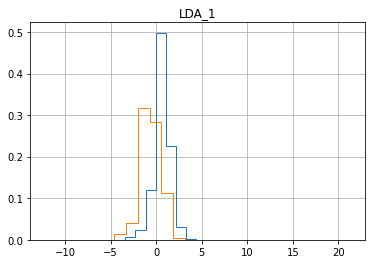

In [121]:
fig, ax = plt.subplots()

for name, df in total_lda.groupby('2year'):

    df.hist(ax=ax, density=True, histtype='step', bins=20)